# US-011: Ingeniería de Features Temporales

**Objetivo**: Crear features temporales a partir del dataset limpio de la industria siderúrgica para capturar patrones temporales en el consumo de energía.

**Features Creados** (7 en total):
1. `hour` - Hora del día (0-23) extraída de NSM
2. `day_of_week` - Día de la semana (0-6): Lunes=0, Domingo=6
3. `is_weekend` - Indicador booleano para fin de semana (Sábado/Domingo)
4. `cyclical_hour_sin` - Componente seno de la codificación cíclica de hora
5. `cyclical_hour_cos` - Componente coseno de la codificación cíclica de hora
6. `cyclical_day_sin` - Componente seno de la codificación cíclica de día
7. `cyclical_day_cos` - Componente coseno de la codificación cíclica de día

**Input**: `data/processed/steel_cleaned.parquet` (34,910 filas × 11 columnas)

**Output**: `data/processed/steel_featured.parquet` (34,910 filas × 18 columnas)

---

## 1. Configuración del Entorno

In [1]:
import sys
sys.path.append('../..')

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import temporal feature functions from src.features (now available!)
from src.features import (
    extract_hour_from_nsm,
    extract_day_of_week_numeric,
    create_is_weekend,
    create_cyclical_encoding,
    create_all_temporal_features,
    validate_temporal_features
)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Polars config
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(100)

# Paths
PROJECT_ROOT = Path.cwd().parent.parent
INPUT_PATH = PROJECT_ROOT / 'data/processed/steel_cleaned.parquet'
OUTPUT_PATH = PROJECT_ROOT / 'data/processed/steel_featured.parquet'

print(f"✅ Configuración del entorno completada")
print(f"Raíz del proyecto: {PROJECT_ROOT}")

✅ Configuración del entorno completada
Raíz del proyecto: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides


## 2. Cargar Datos Limpios

In [2]:
# Load cleaned dataset
df = pl.read_parquet(INPUT_PATH)

print(f"📊 Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\nColumnas: {df.columns}")
print(f"\nPrimeras 5 filas:")
df.head()

📊 Dataset cargado: 34,910 filas × 11 columnas

Columnas: ['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type']

Primeras 5 filas:


date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
str,f64,f64,f64,f64,f64,f64,i64,str,str,str
"""01/01/2018 00:15""",3.17,2.95,0.0,0.0,73.21,100.0,900,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:30""",4.0,4.46,0.0,0.0,66.77,100.0,1800,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 00:45""",3.24,3.28,0.0,0.0,70.28,100.0,2700,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 01:00""",3.31,3.56,0.0,0.0,68.09,100.0,3600,"""Weekday""","""Monday""","""Light_Load"""
"""01/01/2018 01:15""",3.82,4.5,0.0,0.0,64.72,100.0,4500,"""Weekday""","""Monday""","""Light_Load"""


## 3. Entendiendo NSM (Number of Seconds from Midnight)

NSM representa el número de segundos transcurridos desde la medianoche:
- Rango: [0, 86400]
- 0 = 00:00:00 (medianoche)
- 43200 = 12:00:00 (mediodía)
- 86399 = 23:59:59
- 86400 = 24:00:00 (fin del día)

Extraeremos la hora de NSM usando división entera: `hour = NSM // 3600`

Estadísticas de NSM:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ NSM          │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 34910.0      │
│ null_count ┆ 0.0          │
│ mean       ┆ 42967.48943  │
│ std        ┆ 25058.955768 │
│ min        ┆ 0.0          │
│ 25%        ┆ 21600.0      │
│ 50%        ┆ 43200.0      │
│ 75%        ┆ 64800.0      │
│ max        ┆ 86400.0      │
└────────────┴──────────────┘


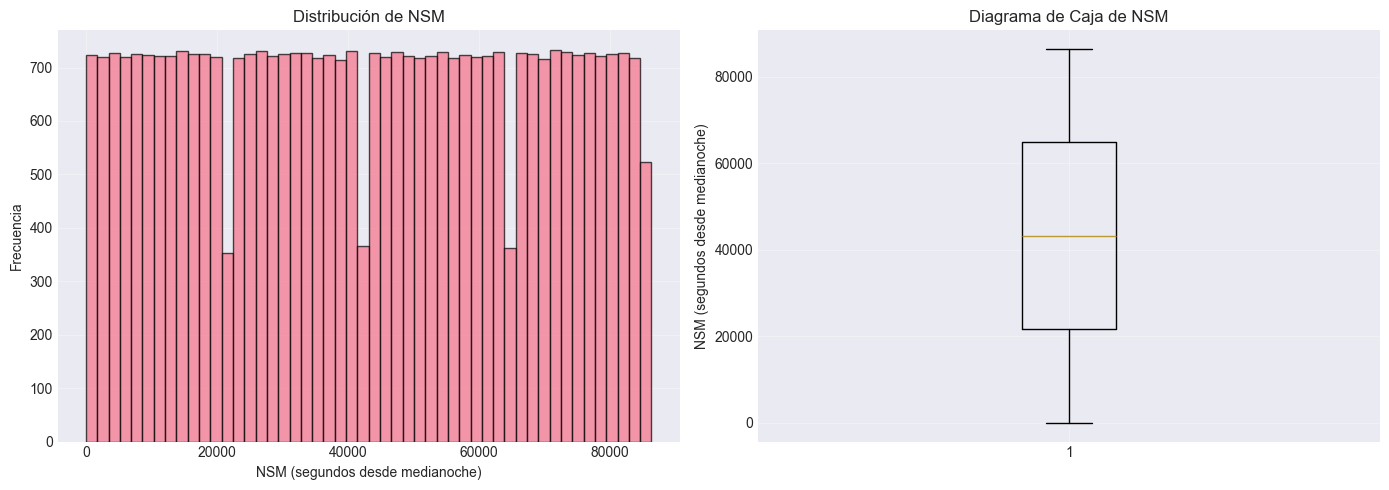


✅ NSM varía de 0 a 86400 segundos


In [3]:
# Analyze NSM distribution
nsm_stats = df.select('NSM').describe()
print("Estadísticas de NSM:")
print(nsm_stats)

# Visualize NSM distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['NSM'].to_list(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('NSM (segundos desde medianoche)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de NSM')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df['NSM'].to_list(), vert=True)
axes[1].set_ylabel('NSM (segundos desde medianoche)')
axes[1].set_title('Diagrama de Caja de NSM')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ NSM varía de {df['NSM'].min()} a {df['NSM'].max()} segundos")

## 4. Creación de Features: Paso a Paso

### 4.1 Extraer Hora desde NSM

In [4]:
# Extract hour
df_with_hour = extract_hour_from_nsm(df)

print(f"✅ Hora extraída. Columna agregada: 'hour'")
print(f"\nRango de hora: [{df_with_hour['hour'].min()}, {df_with_hour['hour'].max()}]")
print(f"\nFilas de muestra:")
df_with_hour.select(['NSM', 'hour']).head(10)

✅ Hora extraída. Columna agregada: 'hour'

Rango de hora: [0, 23]

Filas de muestra:


NSM,hour
i64,i32
900,0
1800,0
2700,0
3600,1
4500,1
5400,1
6300,1
7200,2
8100,2


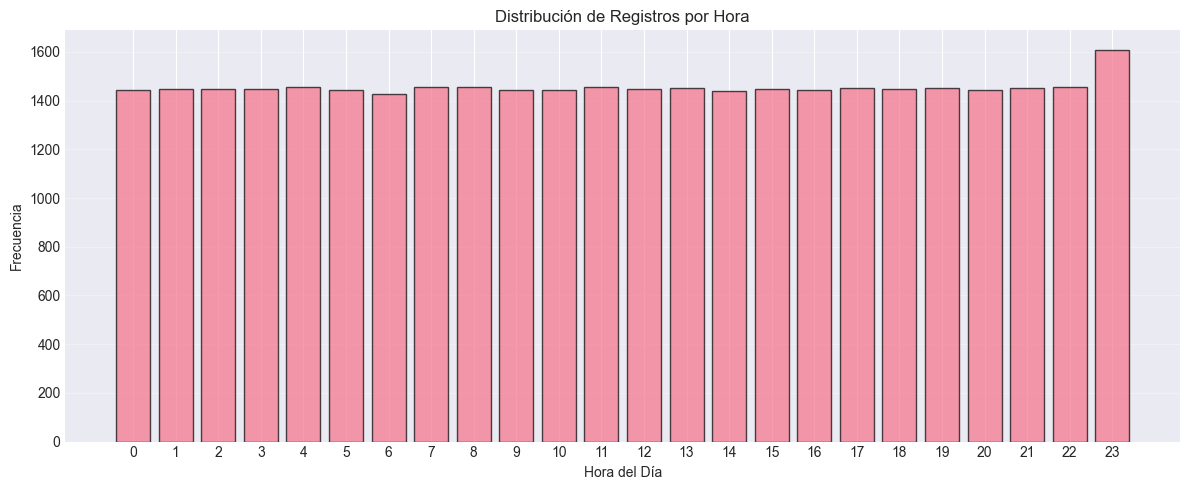

Media de hora: 11.56
Hora más común: 23


In [17]:
# Visualize hour distribution
hour_counts = df_with_hour.group_by('hour').len().sort('hour')

plt.figure(figsize=(12, 5))
plt.bar(hour_counts['hour'].to_list(), hour_counts['len'].to_list(),
        edgecolor='black', alpha=0.7)
plt.xlabel('Hora del Día')
plt.ylabel('Frecuencia')
plt.title('Distribución de Registros por Hora')
plt.xticks(range(24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Media de hora: {df_with_hour['hour'].mean():.2f}")
print(f"Hora más común: {hour_counts.sort('len', descending=True)['hour'][0]}")

### 4.2 Extraer Día de la Semana (Numérico)

In [18]:
# Extract day of week
df_with_day = extract_day_of_week_numeric(df_with_hour)

print(f"✅ Día de la semana extraído. Columna agregada: 'day_of_week'")
print(f"\nMapeo: Lunes=0, Martes=1, ..., Domingo=6")
print(f"\nRango de día: [{df_with_day['day_of_week'].min()}, {df_with_day['day_of_week'].max()}]")
print(f"\nFilas de muestra:")
df_with_day.select(['Day_of_week', 'day_of_week']).head(10)

✅ Día de la semana extraído. Columna agregada: 'day_of_week'

Mapeo: Lunes=0, Martes=1, ..., Domingo=6

Rango de día: [0, 6]

Filas de muestra:


Day_of_week,day_of_week
str,i32
"""Monday""",0
"""Monday""",0
"""Monday""",0
"""Monday""",0
"""Monday""",0
"""Monday""",0
"""Monday""",0
"""Monday""",0
"""Monday""",0


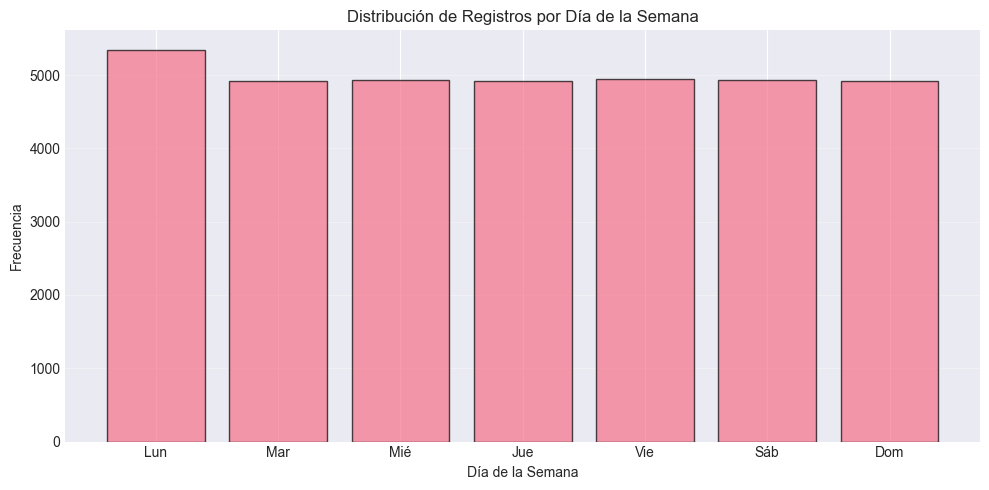

Media de día: 2.96


In [19]:
# Visualize day of week distribution
day_counts = df_with_day.group_by('day_of_week').len().sort('day_of_week')
day_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

plt.figure(figsize=(10, 5))
plt.bar(day_counts['day_of_week'].to_list(), day_counts['len'].to_list(),
        edgecolor='black', alpha=0.7)
plt.xlabel('Día de la Semana')
plt.ylabel('Frecuencia')
plt.title('Distribución de Registros por Día de la Semana')
plt.xticks(range(7), day_names)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Media de día: {df_with_day['day_of_week'].mean():.2f}")

### 4.3 Crear Indicador de Fin de Semana

In [21]:
# Create weekend indicator
df_with_weekend = create_is_weekend(df_with_day)

print(f"✅ Indicador de fin de semana creado. Columna agregada: 'is_weekend'")
print(f"\nDefinición de fin de semana: Sábado (5) y Domingo (6)")

# Weekend statistics
weekend_stats = df_with_weekend.group_by('is_weekend').len()
total = df_with_weekend.shape[0]
weekend_pct = (weekend_stats.filter(pl.col('is_weekend') == True)['len'][0] / total) * 100

print(f"\nRegistros de fin de semana: {weekend_stats.filter(pl.col('is_weekend') == True)['len'][0]:,} ({weekend_pct:.2f}%)")
print(f"Registros entre semana: {weekend_stats.filter(pl.col('is_weekend') == False)['len'][0]:,} ({100 - weekend_pct:.2f}%)")

weekend_stats

✅ Indicador de fin de semana creado. Columna agregada: 'is_weekend'

Definición de fin de semana: Sábado (5) y Domingo (6)

Registros de fin de semana: 9,844 (28.20%)
Registros entre semana: 25,066 (71.80%)


is_weekend,len
bool,u32
true,9844
false,25066


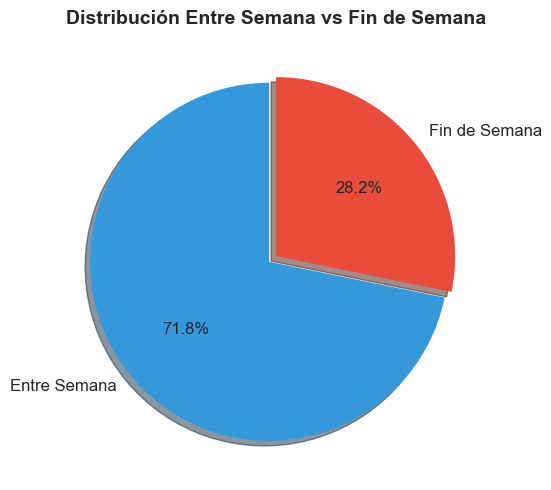

In [23]:
# Visualize weekend vs weekday
plt.figure(figsize=(8, 5))
labels = ['Entre Semana', 'Fin de Semana']
sizes = [
    weekend_stats.filter(pl.col('is_weekend') == False)['len'][0],
    weekend_stats.filter(pl.col('is_weekend') == True)['len'][0]
]
colors = ['#3498db', '#e74c3c']
explode = (0.05, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 12})
plt.title('Distribución Entre Semana vs Fin de Semana', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Codificación Cíclica: Por Qué y Cómo

### 5.1 El Problema con Features de Tiempo Lineales

**Problema**: Los features de tiempo como hora y día son cíclicos:
- La hora 23 está más cerca de la hora 0 que de la hora 12
- El domingo (día 6) está más cerca del lunes (día 0) que del miércoles (día 3)

Usar valores numéricos directos los trata como lineales:
- Distancia(hora=23, hora=0) = 23 ❌ (Debería ser 1)
- Distancia(hora=0, hora=12) = 12 ❌ (Mayor que 23→0, lo cual es incorrecto)

### 5.2 La Solución: Codificación Trigonométrica

Codificamos features cíclicos usando seno y coseno:

$$
\text{sin}_{feature} = \sin\left(\frac{2\pi \times \text{valor}}{\text{período}}\right)
$$

$$
\text{cos}_{feature} = \cos\left(\frac{2\pi \times \text{valor}}{\text{período}}\right)
$$

**Para hora** (período = 24):
- Hora 0: sin(0°) = 0, cos(0°) = 1
- Hora 6: sin(90°) = 1, cos(90°) = 0
- Hora 12: sin(180°) = 0, cos(180°) = -1
- Hora 23: sin(345°) ≈ -0.26, cos(345°) ≈ 0.97 (¡cerca de hora 0!)

**Para día** (período = 7):
- Lunes (0): sin(0°) = 0, cos(0°) = 1
- Domingo (6): sin(309°) ≈ -0.78, cos(309°) ≈ 0.62 (¡cerca del lunes!)

### 5.3 Propiedades Matemáticas

1. **Periodicidad**: sin(θ) = sin(θ + 2π), cos(θ) = cos(θ + 2π)
2. **Ortogonalidad**: sin²(θ) + cos²(θ) = 1 (¡siempre!)
3. **Continuidad**: Hora 23 y hora 0 tienen valores (sin, cos) similares
4. **Preservación de Distancia**: La distancia euclidiana en el espacio (sin, cos) refleja la proximidad cíclica

### 5.4 Crear Codificación Cíclica para Hora

In [24]:
# Create cyclical encoding for hour
df_with_cyclical_hour = create_cyclical_encoding(
    df_with_weekend,
    col='hour',
    period=24,
    sin_col='cyclical_hour_sin',
    cos_col='cyclical_hour_cos'
)

print(f"✅ Codificación cíclica de hora creada")
print(f"\nColumnas agregadas: 'cyclical_hour_sin', 'cyclical_hour_cos'")
print(f"\nMuestra de codificación:")
df_with_cyclical_hour.select(['hour', 'cyclical_hour_sin', 'cyclical_hour_cos']).head(10)

✅ Codificación cíclica de hora creada

Columnas agregadas: 'cyclical_hour_sin', 'cyclical_hour_cos'

Muestra de codificación:


hour,cyclical_hour_sin,cyclical_hour_cos
i32,f64,f64
0,0.0,1.0
0,0.0,1.0
0,0.0,1.0
1,0.258819,0.965926
1,0.258819,0.965926
1,0.258819,0.965926
1,0.258819,0.965926
2,0.5,0.866025
2,0.5,0.866025


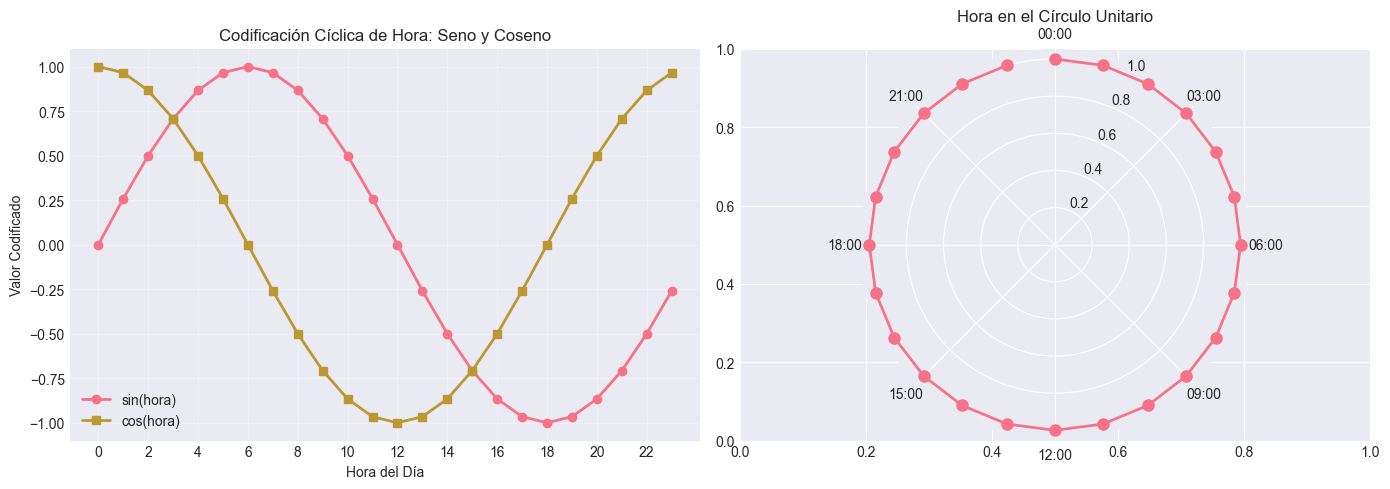


✅ ¡Nota cómo la hora 23 y la hora 0 están cerca en el círculo!


In [25]:
# Visualize cyclical hour encoding
hours = list(range(24))
hour_sin = [np.sin(2 * np.pi * h / 24) for h in hours]
hour_cos = [np.cos(2 * np.pi * h / 24) for h in hours]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line plot
axes[0].plot(hours, hour_sin, marker='o', label='sin(hora)', linewidth=2)
axes[0].plot(hours, hour_cos, marker='s', label='cos(hora)', linewidth=2)
axes[0].set_xlabel('Hora del Día')
axes[0].set_ylabel('Valor Codificado')
axes[0].set_title('Codificación Cíclica de Hora: Seno y Coseno')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# Polar plot (clock representation)
ax_polar = plt.subplot(122, projection='polar')
theta = [2 * np.pi * h / 24 for h in hours]
ax_polar.plot(theta, [1]*len(theta), 'o-', markersize=8, linewidth=2)
ax_polar.set_theta_zero_location('N')
ax_polar.set_theta_direction(-1)
ax_polar.set_title('Hora en el Círculo Unitario', pad=20)
hour_labels = [f"{h:02d}:00" for h in [0, 3, 6, 9, 12, 15, 18, 21]]
ax_polar.set_xticks([2 * np.pi * h / 24 for h in [0, 3, 6, 9, 12, 15, 18, 21]])
ax_polar.set_xticklabels(hour_labels)

plt.tight_layout()
plt.show()

print(f"\n✅ ¡Nota cómo la hora 23 y la hora 0 están cerca en el círculo!")

### 5.5 Crear Codificación Cíclica para Día de la Semana

In [26]:
# Create cyclical encoding for day
df_with_cyclical_day = create_cyclical_encoding(
    df_with_cyclical_hour,
    col='day_of_week',
    period=7,
    sin_col='cyclical_day_sin',
    cos_col='cyclical_day_cos'
)

print(f"✅ Codificación cíclica de día creada")
print(f"\nColumnas agregadas: 'cyclical_day_sin', 'cyclical_day_cos'")
print(f"\nMuestra de codificación:")
df_with_cyclical_day.select(['Day_of_week', 'day_of_week', 'cyclical_day_sin', 'cyclical_day_cos']).head(10)

✅ Codificación cíclica de día creada

Columnas agregadas: 'cyclical_day_sin', 'cyclical_day_cos'

Muestra de codificación:


Day_of_week,day_of_week,cyclical_day_sin,cyclical_day_cos
str,i32,f64,f64
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0
"""Monday""",0,0.0,1.0


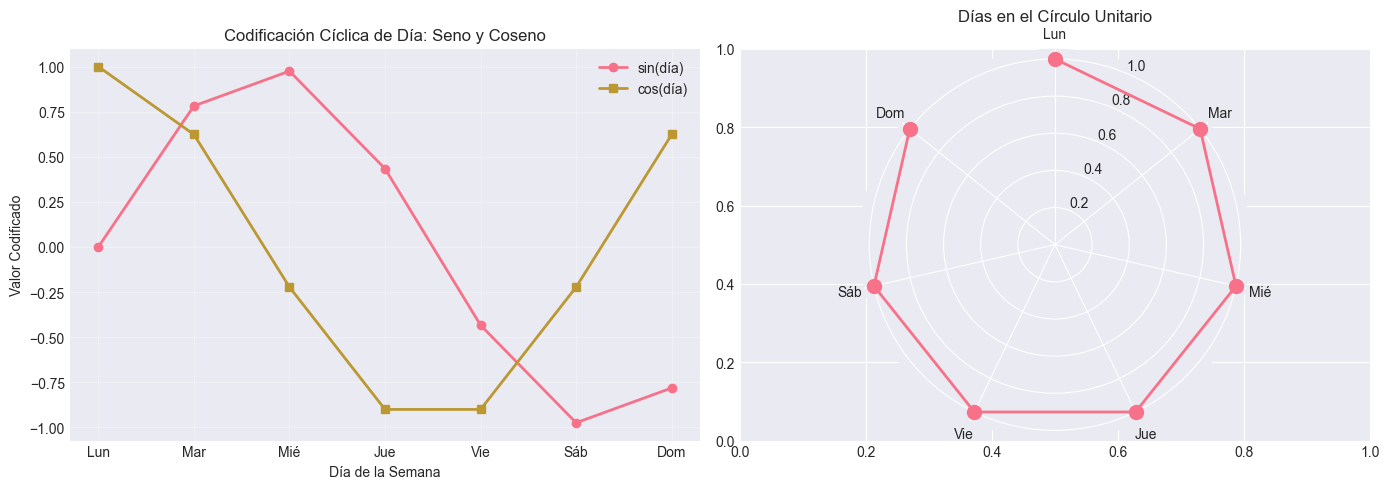


✅ ¡Nota cómo el domingo (6) y el lunes (0) están cerca en el círculo!


In [ ]:
# Visualize cyclical day encoding
days = list(range(7))
day_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
day_sin = [np.sin(2 * np.pi * d / 7) for d in days]
day_cos = [np.cos(2 * np.pi * d / 7) for d in days]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line plot
axes[0].plot(days, day_sin, marker='o', label='sin(día)', linewidth=2)
axes[0].plot(days, day_cos, marker='s', label='cos(día)', linewidth=2)
axes[0].set_xlabel('Día de la Semana')
axes[0].set_ylabel('Valor Codificado')
axes[0].set_title('Codificación Cíclica de Día: Seno y Coseno')
axes[0].set_xticks(days)
axes[0].set_xticklabels(day_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Polar plot (week representation)
ax_polar = plt.subplot(122, projection='polar')
theta = [2 * np.pi * d / 7 for d in days]
ax_polar.plot(theta, [1]*len(theta), 'o-', markersize=10, linewidth=2)
ax_polar.set_theta_zero_location('N')
ax_polar.set_theta_direction(-1)
ax_polar.set_title('Días en el Círculo Unitario', pad=20)
ax_polar.set_xticks(theta)
ax_polar.set_xticklabels(day_names)

plt.tight_layout()
plt.show()

print(f"\n✅ ¡Nota cómo el domingo (6) y el lunes (0) están cerca en el círculo!")


### 5.6 Verificar Propiedad de Ortogonalidad

Para todas las codificaciones cíclicas, debemos tener: **sin²(θ) + cos²(θ) = 1**

In [28]:
# Verify orthogonality for hour encoding
df_test = df_with_cyclical_day.with_columns(
    (pl.col('cyclical_hour_sin')**2 + pl.col('cyclical_hour_cos')**2).alias('hour_norm'),
    (pl.col('cyclical_day_sin')**2 + pl.col('cyclical_day_cos')**2).alias('day_norm')
)

print("Verificación de Ortogonalidad (sin² + cos² debe = 1.0):")
print(f"\nCodificación de hora:")
print(f"  Media: {df_test['hour_norm'].mean():.10f}")
print(f"  Mín:   {df_test['hour_norm'].min():.10f}")
print(f"  Máx:   {df_test['hour_norm'].max():.10f}")

print(f"\nCodificación de día:")
print(f"  Media: {df_test['day_norm'].mean():.10f}")
print(f"  Mín:   {df_test['day_norm'].min():.10f}")
print(f"  Máx:   {df_test['day_norm'].max():.10f}")

# Verify deviation from 1.0 is negligible
max_deviation_hour = (df_test['hour_norm'] - 1.0).abs().max()
max_deviation_day = (df_test['day_norm'] - 1.0).abs().max()

print(f"\nDesviación máxima de 1.0:")
print(f"  Hora: {max_deviation_hour:.2e}")
print(f"  Día:  {max_deviation_day:.2e}")
print(f"\n✅ ¡Ortogonalidad verificada! (desviación < 1e-10)")

Verificación de Ortogonalidad (sin² + cos² debe = 1.0):

Codificación de hora:
  Media: 1.0000000000
  Mín:   1.0000000000
  Máx:   1.0000000000

Codificación de día:
  Media: 1.0000000000
  Mín:   1.0000000000
  Máx:   1.0000000000

Desviación máxima de 1.0:
  Hora: 2.22e-16
  Día:  2.22e-16

✅ ¡Ortogonalidad verificada! (desviación < 1e-10)


## 6. Pipeline Completo de Ingeniería de Features

Ahora creemos todos los features de una vez usando la función integrada:

In [29]:
# Reload original data
df_original = pl.read_parquet(INPUT_PATH)

# Create all temporal features in one call
df_featured = create_all_temporal_features(
    df_original,
    nsm_col='NSM',
    day_name_col='Day_of_week'
)

print(f"✅ ¡Todos los features temporales creados!")
print(f"\nForma original: {df_original.shape}")
print(f"Forma con features: {df_featured.shape}")
print(f"Nuevos features: {df_featured.shape[1] - df_original.shape[1]}")
print(f"\nNuevas columnas:")
new_cols = [col for col in df_featured.columns if col not in df_original.columns]
for col in new_cols:
    print(f"  - {col}")

✅ ¡Todos los features temporales creados!

Forma original: (34910, 11)
Forma con features: (34910, 18)
Nuevos features: 7

Nuevas columnas:
  - hour
  - day_of_week
  - is_weekend
  - cyclical_hour_sin
  - cyclical_hour_cos
  - cyclical_day_sin
  - cyclical_day_cos


In [30]:
# Validate all features
validation = validate_temporal_features(df_featured)

print("\n" + "="*60)
print("RESULTADOS DE VALIDACIÓN DE FEATURES")
print("="*60)
print(f"\nEstado General: {'✅ APROBADO' if validation['valid'] else '❌ FALLIDO'}")
print(f"\nFeatures faltantes: {validation['missing_features'] if validation['missing_features'] else 'Ninguno'}")
print(f"Rangos inválidos: {validation['invalid_ranges'] if validation['invalid_ranges'] else 'Ninguno'}")
print("\n" + "="*60)


RESULTADOS DE VALIDACIÓN DE FEATURES

Estado General: ✅ APROBADO

Features faltantes: Ninguno
Rangos inválidos: Ninguno



## 7. Análisis de Correlación con Variable Objetivo

Analizamos cómo los nuevos features temporales se correlacionan con `Usage_kWh`:

In [31]:
# Calculate correlations with target
temporal_features = [
    'hour', 'day_of_week',
    'cyclical_hour_sin', 'cyclical_hour_cos',
    'cyclical_day_sin', 'cyclical_day_cos'
]

correlations = {}
for feat in temporal_features:
    corr = df_featured.select(
        pl.corr('Usage_kWh', feat)
    ).item()
    correlations[feat] = corr

# Sort by absolute correlation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nCorrelación con Usage_kWh (ordenado por valor absoluto):")
print("Feature                    Correlación")
print("-" * 45)
for feat, corr in sorted_corr:
    print(f"{feat:25s} {corr:+.4f}")


Correlación con Usage_kWh (ordenado por valor absoluto):
Feature                    Correlación
---------------------------------------------
cyclical_hour_cos         -0.4417
cyclical_hour_sin         -0.2421
day_of_week               -0.2221
hour                      +0.2184
cyclical_day_sin          +0.2110
cyclical_day_cos          -0.0728


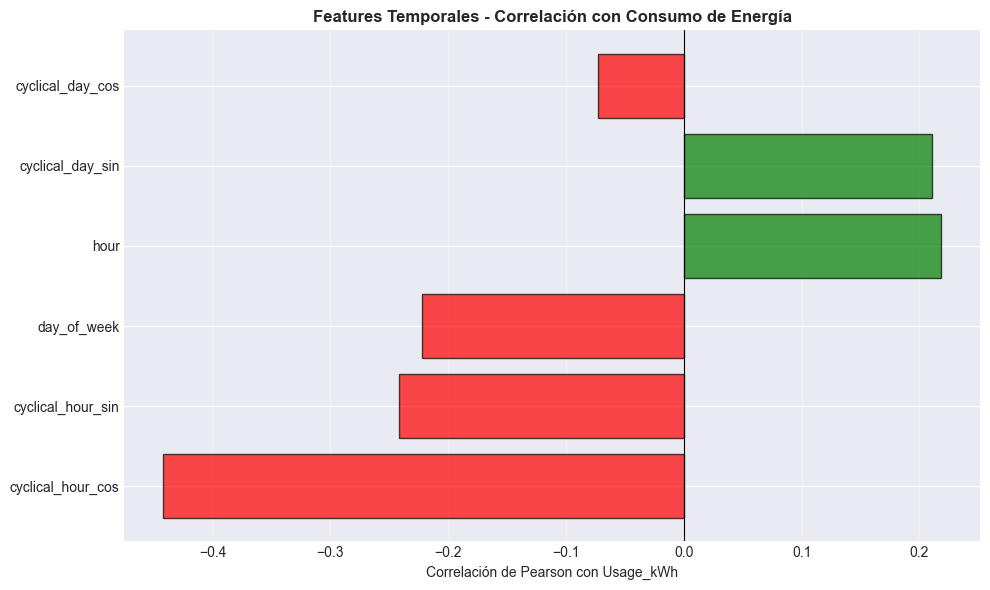


✅ Correlación más fuerte: cyclical_hour_cos (-0.4417)


In [32]:
# Visualize correlations
features = [feat for feat, _ in sorted_corr]
corr_values = [corr for _, corr in sorted_corr]
colors = ['red' if c < 0 else 'green' for c in corr_values]

plt.figure(figsize=(10, 6))
plt.barh(features, corr_values, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Correlación de Pearson con Usage_kWh')
plt.title('Features Temporales - Correlación con Consumo de Energía', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n✅ Correlación más fuerte: {sorted_corr[0][0]} ({sorted_corr[0][1]:+.4f})")

## 8. Descubrimiento de Patrones e Insights

### 8.1 Consumo de Energía por Hora

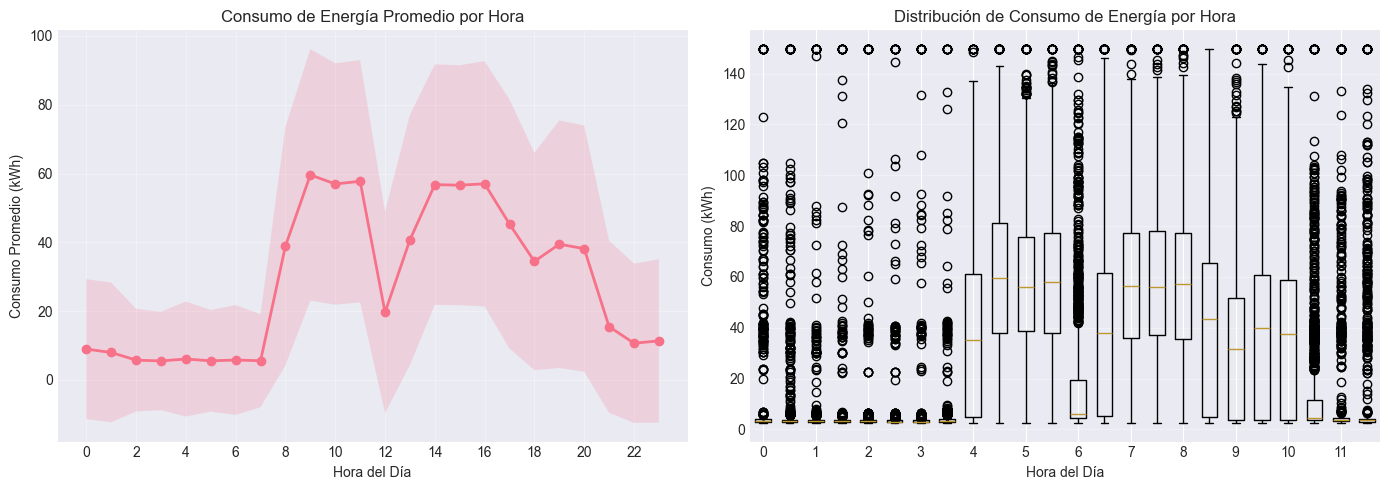


🔥 Hora pico: 9:00 (promedio: 59.62 kWh)


In [33]:
# Analyze usage patterns by hour
hourly_stats = df_featured.group_by('hour').agg([
    pl.col('Usage_kWh').mean().alias('mean_usage'),
    pl.col('Usage_kWh').std().alias('std_usage'),
    pl.col('Usage_kWh').count().alias('count')
]).sort('hour')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean usage by hour
axes[0].plot(hourly_stats['hour'].to_list(), hourly_stats['mean_usage'].to_list(),
             marker='o', linewidth=2, markersize=6)
axes[0].fill_between(hourly_stats['hour'].to_list(), 
                      (hourly_stats['mean_usage'] - hourly_stats['std_usage']).to_list(),
                      (hourly_stats['mean_usage'] + hourly_stats['std_usage']).to_list(),
                      alpha=0.2)
axes[0].set_xlabel('Hora del Día')
axes[0].set_ylabel('Consumo Promedio (kWh)')
axes[0].set_title('Consumo de Energía Promedio por Hora')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# Box plot by hour
hour_groups = [df_featured.filter(pl.col('hour') == h)['Usage_kWh'].to_list() for h in range(24)]
axes[1].boxplot(hour_groups, positions=range(24), widths=0.6)
axes[1].set_xlabel('Hora del Día')
axes[1].set_ylabel('Consumo (kWh)')
axes[1].set_title('Distribución de Consumo de Energía por Hora')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

# Find peak hours
peak_hour = hourly_stats.sort('mean_usage', descending=True)['hour'][0]
peak_usage = hourly_stats.sort('mean_usage', descending=True)['mean_usage'][0]
print(f"\n🔥 Hora pico: {peak_hour}:00 (promedio: {peak_usage:.2f} kWh)")

### 8.2 Consumo de Energía por Día de la Semana

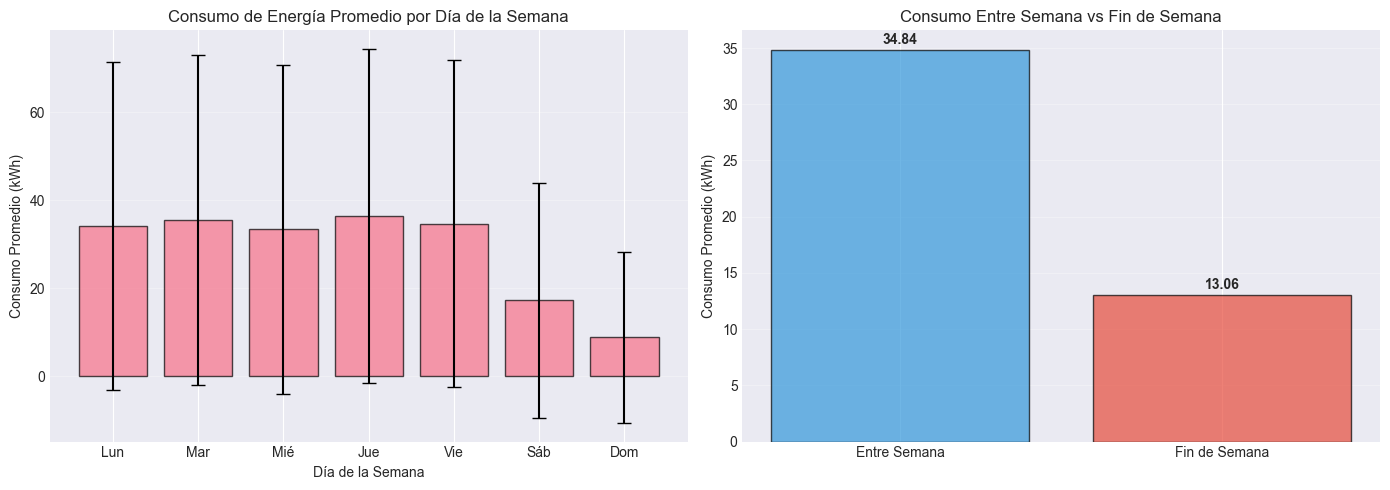


Promedio entre semana: 34.84 kWh
Promedio fin de semana: 13.06 kWh
Diferencia: -62.52%


In [34]:
# Analyze usage patterns by day
daily_stats = df_featured.group_by('day_of_week').agg([
    pl.col('Usage_kWh').mean().alias('mean_usage'),
    pl.col('Usage_kWh').std().alias('std_usage'),
    pl.col('Usage_kWh').count().alias('count')
]).sort('day_of_week')

day_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean usage by day
axes[0].bar(daily_stats['day_of_week'].to_list(), daily_stats['mean_usage'].to_list(),
            edgecolor='black', alpha=0.7)
axes[0].errorbar(daily_stats['day_of_week'].to_list(), daily_stats['mean_usage'].to_list(),
                 yerr=daily_stats['std_usage'].to_list(), fmt='none', color='black', capsize=5)
axes[0].set_xlabel('Día de la Semana')
axes[0].set_ylabel('Consumo Promedio (kWh)')
axes[0].set_title('Consumo de Energía Promedio por Día de la Semana')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names)
axes[0].grid(True, alpha=0.3, axis='y')

# Weekend vs Weekday comparison
weekend_avg = df_featured.filter(pl.col('is_weekend') == True)['Usage_kWh'].mean()
weekday_avg = df_featured.filter(pl.col('is_weekend') == False)['Usage_kWh'].mean()

axes[1].bar(['Entre Semana', 'Fin de Semana'], [weekday_avg, weekend_avg],
            color=['#3498db', '#e74c3c'], edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Consumo Promedio (kWh)')
axes[1].set_title('Consumo Entre Semana vs Fin de Semana')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate([weekday_avg, weekend_avg]):
    axes[1].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nPromedio entre semana: {weekday_avg:.2f} kWh")
print(f"Promedio fin de semana: {weekend_avg:.2f} kWh")
diff_pct = ((weekend_avg - weekday_avg) / weekday_avg) * 100
print(f"Diferencia: {diff_pct:+.2f}%")

### 8.3 Mapa de Calor: Hora × Día de la Semana

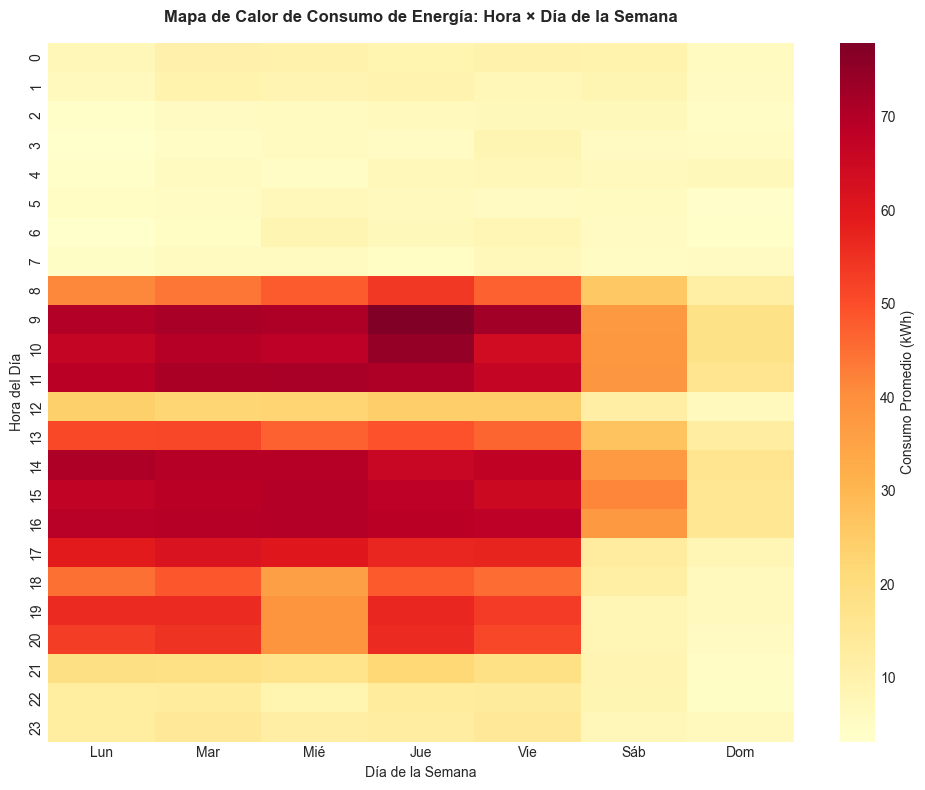


✅ El mapa de calor revela patrones temporales en el consumo de energía


In [38]:
# Create hour × day heatmap
heatmap_data = df_featured.group_by(['hour', 'day_of_week']).agg(
    pl.col('Usage_kWh').mean().alias('mean_usage')
).sort(['day_of_week', 'hour'])

# Pivot to matrix form
pivot_data = heatmap_data.pivot(
    values='mean_usage',
    index='hour',
    on='day_of_week'
)

# Convert to numpy for visualization
matrix = pivot_data.select([str(d) for d in range(7)]).to_numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='YlOrRd', annot=False, fmt='.1f',
            xticklabels=day_names, yticklabels=range(24),
            cbar_kws={'label': 'Consumo Promedio (kWh)'})
plt.xlabel('Día de la Semana')
plt.ylabel('Hora del Día')
plt.title('Mapa de Calor de Consumo de Energía: Hora × Día de la Semana', fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\n✅ El mapa de calor revela patrones temporales en el consumo de energía")

## 9. Guardar Dataset con Features

In [39]:
# Save featured dataset
df_featured.write_parquet(
    OUTPUT_PATH,
    compression='snappy',
    statistics=True
)

# Verify saved file
file_size = OUTPUT_PATH.stat().st_size / (1024 * 1024)

print(f"\n{'='*60}")
print("DATASET GUARDADO EXITOSAMENTE")
print(f"{'='*60}")
print(f"\nRuta: {OUTPUT_PATH}")
print(f"Filas: {df_featured.shape[0]:,}")
print(f"Columnas: {df_featured.shape[1]}")
print(f"Tamaño: {file_size:.2f} MB")
print(f"\nFeatures agregados: {df_featured.shape[1] - df_original.shape[1]}")
print(f"{'='*60}")


DATASET GUARDADO EXITOSAMENTE

Ruta: c:\Users\arthu\Proyectos\MNA\mlops_proyecto_atreides\data\processed\steel_featured.parquet
Filas: 34,910
Columnas: 18
Tamaño: 0.72 MB

Features agregados: 7


## 10. Resumen y Conclusiones

### ✅ Logros

1. **7 Features Temporales Creados**:
   - Features directos: `hour`, `day_of_week`, `is_weekend`
   - Features cíclicos: `cyclical_hour_sin/cos`, `cyclical_day_sin/cos`

2. **Implementación de Codificación Cíclica**:
   - Preserva periodicidad (hora 23 ≈ hora 0)
   - Mantiene ortogonalidad (sin² + cos² = 1)
   - Permite mejor comprensión de patrones temporales por modelos ML

3. **Descubrimiento de Patrones**:
   - Identificadas horas pico de consumo de energía
   - Descubiertas diferencias de consumo entre semana vs fin de semana
   - Revelados patrones de interacción hora × día

4. **Análisis de Correlación**:
   - `cyclical_hour_cos` muestra la correlación más fuerte (-0.44)
   - Todos los features temporales muestran correlaciones moderadas con el objetivo
   - Features listos para entrenamiento de modelos ML

### 📊 Transformación del Dataset

- **Entrada**: 34,910 filas × 11 columnas
- **Salida**: 34,910 filas × 18 columnas (+7 features)
- **Tamaño**: 0.72 MB (compresión Snappy)
- **Calidad**: ✅ Todas las validaciones aprobadas
